In [1]:
# IMPORT MODULES
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model

import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
# -----------------------------1.客製化模型--------------------------------
# 載入keras模型(更換輸出圖片尺寸)
from keras.applications import DenseNet201
model = DenseNet201(include_top=False,
                 weights='imagenet',
                 input_tensor=Input(shape=(48, 48, 1))
                 )

# 定義輸出層
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

# 編譯模型
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#######################################################
# 目前只有測試到這裡!! 還有儲存模型

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
# ---------------------------2.設置callbacks----------------------------
# 設定earlystop條件
estop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# 設定模型儲存條件
checkpoint = ModelCheckpoint('Densenet201_checkpoint_v2.h5', verbose=1,
                          monitor='val_loss', save_best_only=True,
                          mode='min')

# 設定lr降低條件(0.001 → 0.0002 → 0.00004 → 0.00001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                           patience=5, mode='min', verbose=1,
                           min_lr=1e-4)

In [4]:
# # -----------------------------3.設置資料集--------------------------------
# # 設定ImageDataGenerator參數(路徑、批量、圖片尺寸)
# train_dir = './workout/train/'
# valid_dir = './workout/val/'
# test_dir = './workout/test/'
# batch_size = 64
# target_size = (80, 80)

# # 設定批量生成器
# train_datagen = ImageDataGenerator(rescale=1./255, 
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2, 
#                                    zoom_range=0.5,
#                                    fill_mode="nearest")

# val_datagen = ImageDataGenerator(rescale=1./255)

# test_datagen = ImageDataGenerator(rescale=1./255)

# # 讀取資料集+批量生成器，產生每epoch訓練樣本
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                       target_size=target_size,
#                                       batch_size=batch_size)

# valid_generator = val_datagen.flow_from_directory(valid_dir,
#                                       target_size=target_size,
#                                       batch_size=batch_size)

# test_generator = test_datagen.flow_from_directory(test_dir,
#                                       target_size=target_size,
#                                       batch_size=batch_size,
#                                       shuffle=False)

In [5]:
# settings

# all_data_path = '../input' # for kaggle
all_data_path = r'E:/other_data/' # for local
# all_data_path = 'D:/dont_move/kaggle_input' # for big data

test_data_path = all_data_path+r'/digit-recognizer/test.csv'
train_data_path = all_data_path+r'/digit-recognizer/train.csv'
# error_enhance_path = [all_data_path+'/mnist-error-enhance/error_enhance', '.csv']

# checkpoint_path = "./checkpoint/train_checkpoint"
# checkpoint_dir = "./checkpoint"
# final_checkpoint = './checkpoint/final_checkpoint'
# final_model = './saved_model/final_model'

In [6]:
# 讀取資料
train_val_data = pd.read_csv(train_data_path)
# 取得 train_data 的 label
train_val_label = train_val_data['label']
# 取得 train_data 的 image
train_val_pic = train_val_data.iloc[:,1:].values.reshape(-1,28,28,1)  # 從1開始是因為第一行是 label 
train_val_pic = train_val_pic.astype("uint8")

# 因為圖片太小 要resize放大
import cv2
train_val_pic = np.concatenate([ cv2.resize( temp_pic, (48,48)).reshape(1,48,48,1) for temp_pic in train_val_pic ], axis = 0)

print('train_val_label shape:', train_val_label.shape)
print('train_val_pic shape:', train_val_pic.shape)

train_val_label shape: (42000,)
train_val_pic shape: (42000, 48, 48, 1)


(48, 48, 1)
<class 'numpy.ndarray'>
uint8


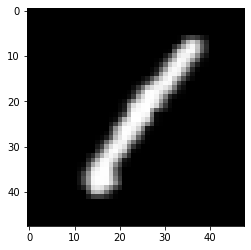

In [7]:
print(train_val_pic[0].shape)
print(type(train_val_pic[0]))
print(train_val_pic[0].dtype)
resize_pic = cv2.resize(train_val_pic[0], (48,48))
plt.imshow( resize_pic, cmap=plt.get_cmap('gray'))


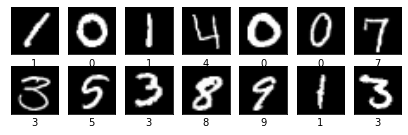

In [8]:
# 確認 train_val_pic 沒問題
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.figure(figsize=(7,2))  # 設定這個 plt 要顯示的大小
for i in range(14):
    plt.subplot(2,7,i+1)     # 切換到對應要顯示的位置
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_val_pic[i], cmap=plt.get_cmap('gray'))  # 這裡要注意不管有沒有 /255，印出來的圖片都會長的一樣
    plt.xlabel(class_names[int(train_val_label[i])])
plt.show()

In [9]:
# 確定資料沒問題後 開始調整至符合 input 跟 output 的形狀
train_val_pic = train_val_pic.reshape((train_val_label.shape[0], 48, 48, 1)).astype('float64') /255.0

In [10]:
# 通常會用 test_data 當作 valid_data
# 但因為kaggle沒有給 所以就再從train_data分出來

# Split data
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
train_val_label = to_categorical(train_val_label)
train_pic, val_pic , train_label, val_label = train_test_split(train_val_pic, train_val_label, 
    test_size=0.1, random_state=200)
    # random_state 如果想要重現一樣的結果 就代入同樣的數字 有點像 random seed

# 這時候就不能再用 for 印 plot 
# 因為 dataset 已經分成兩組 且打亂了
# 所以有些 位置 已經被抽走了 所以會造成 Key error
    
print('train_pic shape:', train_pic.shape)
print('val_pic shape:', val_pic.shape)
print('train_label shape:', train_label.shape)
print('val_label shape:', val_label.shape)

train_pic shape: (37800, 48, 48, 1)
val_pic shape: (4200, 48, 48, 1)
train_label shape: (37800, 10)
val_label shape: (4200, 10)


In [11]:
# because of using tensorflow 的 mnist dataset can improve accuracy 
# so I try to generate more inputs by using ImageDataGenerator
# 多樣化 input
train_flow = None
data_gen = ImageDataGenerator(rotation_range = 20,
                          width_shift_range = 0.1,
                          height_shift_range = 0.1,
                          horizontal_flip = False,
                          vertical_flip = False,
                          fill_mode = 'constant',
                          cval = 0,  
                          data_format = 'channels_last'
                        )

train_flow = data_gen.flow(train_pic, train_label)

In [14]:
# -----------------------------4.開始訓練模型------------------------------
# 重新訓練權重
history = model.fit(train_flow, \
                   epochs=50, verbose=1,
                   validation_data=(val_pic, val_label),
                   callbacks=[checkpoint, estop, reduce_lr])

Epoch 1/50


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: input depth must be evenly divisible by filter depth: 1 vs 7
	 [[{{node conv1/conv/convolution}}]]
	 [[metrics/accuracy/Identity/_10099]]
  (1) Invalid argument: input depth must be evenly divisible by filter depth: 1 vs 7
	 [[{{node conv1/conv/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
# -----------------------5.儲存模型------------------------
# save_model_name = "Densenet201_retrained_v2.h5"
save_model_name = "Densenet201_retrained_v2.pb"
# save_model_name = "Densenet201_retrained_v2.pbtxt"
model.save('./' + save_model_name)
print('已儲存'+save_model_name)

已儲存./save_model/Densenet201_retrained_v2.pb


In [ ]:
import tensorflow as tf
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    frozen_graph = tf.graph_util.convert_variables_to_constants(
        sess, tf.get_default_graph().as_graph_def(), ['conv_3/BiasAdd'])

    tf.io.write_graph(frozen_graph, "../pb/", "frozen_model.pb", as_text=False)
    tf.io.write_graph(frozen_graph, "../pb/", "frozen_model.pbtxt", as_text=True)

    tf.summary.FileWriter(OUTPUT_PATH, graph=frozen_graph, filename_suffix='_model_value')

In [ ]:
# -----------------------6.紀錄學習曲線------------------------
# 畫出acc學習曲線
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.grid()
# 儲存acc學習曲線
plt.savefig('./acc.png')
plt.show()

# 畫出loss學習曲線
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid()
# 儲存loss學習曲線
plt.savefig('loss.png')
plt.show()